<h1 style='text-align:center; text-transform: uppercase; text-decoration: underline;'>PROYECTO INTEGRADOR</h1>
<br>
<p style='font-size:15px;'><span style='text-decoration: underline;'>Materia</span>: Procesamiento de Señales.</p>
<p style='font-size:15px;'><span style='text-decoration: underline;'>Tema</span>: Reconstrucción de tomografías computarizadas con luz visible.</p>
<p style='font-size:15px;'><span style='text-decoration: underline;'>Alumno</span>: Pedro Tagliani.</p>
<br>

<h3>Librerías a utilizar:</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
from tqdm import tqdm
from skimage.transform import iradon
import tifffile as tif
from IPython.core.display import HTML as Center

# import imagej

In [2]:
Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

<h2>1. Procesamiento del video:</h2>

<p style="text-align: justify;">El video original fue recortado usando la herramienta LosslessCut para deshacerse de las partes que no aportaba nada al desarrollo del trabajo.</p>

In [13]:
# Ubicación del video
path = "Archivos/"

# Se carga el video de la botella:
bottle_video = cv2.VideoCapture(path + "Botella_4K_60fps.mp4")

# Información original del video:
n_frames = int(bottle_video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(bottle_video.get(cv2.CAP_PROP_FPS))
duration = int(bottle_video.get(cv2.CAP_PROP_FRAME_COUNT)/bottle_video.get(cv2.CAP_PROP_FPS))
frame_width = int(bottle_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(bottle_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f'Cantidad de frames: {n_frames}.')
print(f'FPS: {fps}.')
print(f'Duración: {duration} segundos.')
print(f'Resolución: {frame_width}x{frame_height} píxeles (4K).')

Cantidad de frames: 3721.
FPS: 60.
Duración: 62 segundos.
Resolución: 2160x3840 píxeles (4K).


In [ ]:
# Por comodidad y tema de rendimiento, se pasa el video de 4K 60FPS a 1080p 60FPS:

fourcc1 = cv2.VideoWriter_fourcc(*'mp4v')
out3 = cv2.VideoWriter('codeData/Botella_1080p_60fps.mp4',fourcc, bottle_video.get(cv2.CAP_PROP_FPS), (1080,1920))

while True:
    success5, frame1 = bottle_video.read()
    if success5 == True:
        b = cv2.resize(frame1,(1080,1920))
        out3.write(b)
    else:
        break
    
bottle_video.release()
out3.release()
cv2.destroyAllWindows()

# Una vez ya se cuenta con el video, no es necesario volver a ejecutar esta celda en futuras ejecuciones
# (El proceso tarda en completarse)

In [14]:
bottle_video = cv2.VideoCapture("codeData/Botella_1080p_60fps.mp4")

# Información modificada del video:
n_frames = int(bottle_video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(bottle_video.get(cv2.CAP_PROP_FPS))
duration = int(bottle_video.get(cv2.CAP_PROP_FRAME_COUNT)/bottle_video.get(cv2.CAP_PROP_FPS))
frame_width = int(bottle_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(bottle_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f'Cantidad de frames: {n_frames}.')
print(f'FPS: {fps}.')
print(f'Duración: {duration} segundos.')
print(f'Resolución: {frame_width}x{frame_height} píxeles (1080p FHD).')

Cantidad de frames: 3721.
FPS: 60.
Duración: 62 segundos.
Resolución: 1080x1920 píxeles (1080p FHD).


In [15]:
# Se busca el frame donde aparece la revista, el cual es usado para rectificar la grabación:
time_frame_for_reference = 6 # Momento en segundos donde se encuentra el frame en cuestión (selección manual al ver el video)
number_frame_for_reference = fps * time_frame_for_reference
print(f'El frame usado como referencia es el N°{number_frame_for_reference}.\n')

# Se extrae dicho frame del video:
bottle_video.set(cv2.CAP_PROP_POS_FRAMES, number_frame_for_reference-1) # CAP_PROP_POS_FRAMES = 0-based index of the frame to be decoded/captured next
# https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359
# https://stackoverflow.com/questions/33650974/opencv-python-read-specific-frame-using-videocapture
# https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d

success1, frame_for_reference = bottle_video.read()
cv2.imwrite('codeData/imagen_referencia.png', frame_for_reference)

# Se muestra la imagen a través de una ventana con una resolución de 432x768 píxeles:
# https://answers.opencv.org/question/84985/resizing-the-output-window-of-imshow-function/
cv2.namedWindow("Window", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Window", 432, 768)
cv2.imshow('Window', frame_for_reference)
cv2.waitKey(0) # https://stackoverflow.com/questions/51143458/difference-in-output-with-waitkey0-and-waitkey1
cv2.destroyAllWindows()

# Una vez seleccionado el frame, se setea el video de nuevo a 0:
bottle_video.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Se busca otro frame para mostrar de ejemplo el resultado de la transformación de forma clara:
time_frame_bottle_ex = 16 # Momento en segundos donde se encuentra el frame en cuestión (selección manual al ver el video)
bottle_video.set(cv2.CAP_PROP_POS_FRAMES, (fps*time_frame_bottle_ex)-1) # CAP_PROP_POS_FRAMES = 0-based index of the frame to be decoded/captured next
success2, frame_bottle_ex_read = bottle_video.read()
cv2.imwrite('codeData/imagen_botella_ejemplo.png', frame_bottle_ex_read)
bottle_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
frame_bottle_ex = cv2.imread('codeData/imagen_botella_ejemplo.png')

El frame usado como referencia es el N°360.



<p style="text-align: justify;">Lo que se busca ahora es rectificar el video, donde se hará uso de una matriz de transformación geométrica. De esta forma se requiere obtener las siguientes coordenadas:
</p>
<ul style="text-align: justify;">
    <li>Source points: Corresponden a las coordenadas (x,y) tomadas como referencia para rectificar el video, los cuales se obtendrán de forma aproximada a través de la visualización de la imagen en cuestión.</li>
    <li>Destination points: Corresponden a las coordenadas (x,y) donde los puntos explicados arriba tendrán que trasladarse.</li>
</ul>

<p style="text-align: justify;">La imagen utilizada como guía para marcar los puntos (x,y) es la siguiente:</p>
<br>
<img src="Archivos/imagen_referencia_lineas.png" width="270" height="480">

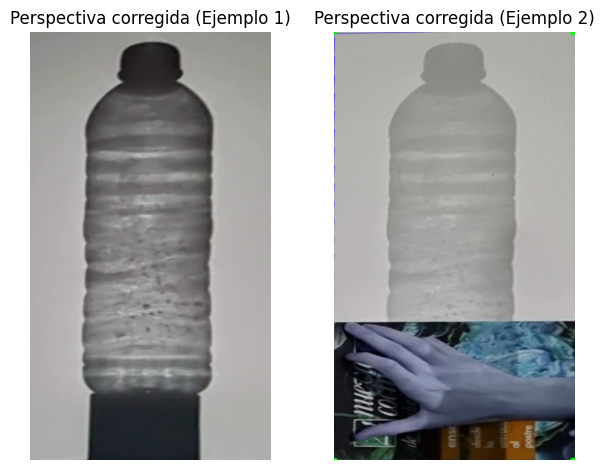

In [16]:
# https://medium.com/analytics-vidhya/opencv-perspective-transformation-9edffefb2143
# https://www.youtube.com/watch?v=y1EgAzQLB_o

frame_reference_lines = cv2.imread('Archivos/imagen_referencia_lineas.png')

# Coordenadas de referencia ordenados en top left, top right, bottom left, bottom right:
pts_source = np.float32([[622,318],[894,420],[648,1290],[926,1269]])

# Coordenadas del destino ordenadas en top left, top right, bottom left, bottom right:
pts_destination = np.float32([[0,0],[1080,0],[0,1920],[1080,1920]])

for val in pts_source:
    cv2.circle(frame_reference_lines,center = (int(val[0]),int(val[1])), radius = 5, color = (0,255,0), thickness = -1)

cv2.namedWindow("Puntos", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Puntos", 432, 768)
cv2.imshow("Puntos", frame_reference_lines)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Se obtiene la matriz de transformación para este caso:
transformation_matrix = cv2.getPerspectiveTransform(pts_source,pts_destination)

# Se muestran dos ejemplos para ver cómo quedó:
transformation_frame_ex1 = cv2.warpPerspective(frame_bottle_ex,transformation_matrix,(1080,1920))
transformation_frame_ex2 = cv2.warpPerspective(frame_reference_lines,transformation_matrix,(1080,1920))

fig1 = plt.figure()

ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(transformation_frame_ex1)
ax1.set_title('Perspectiva corregida (Ejemplo 1)')
ax1.axis('off')

ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(transformation_frame_ex2)
ax2.set_title('Perspectiva corregida (Ejemplo 2)')
ax2.axis('off')

fig1.tight_layout()
plt.show()

In [7]:
# Se repite lo mismo para cada uno de los frames del video:

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec para formato MP4
out2 = cv2.VideoWriter('codeData/Botella_transformed.mp4',fourcc, bottle_video.get(cv2.CAP_PROP_FPS),(1080,1920))

while True:
    success3, frame_to_transform = bottle_video.read()
    if success3 == True:
        transformed_frame = cv2.warpPerspective(frame_to_transform,transformation_matrix,(1080,1920))
        out2.write(transformed_frame)
    else:
        break
    
bottle_video.release()
out2.release()
cv2.destroyAllWindows()

In [17]:
bottle_video_transformed = cv2.VideoCapture('codeData/Botella_transformed.mp4')

# Se separan del video las partes de interés:
scan = []
flat = []
dark = []

frames_scan_start = fps*17 - 1
frames_scan_end = fps*34 - 1

frames_flat_start = fps*39 -1
frames_flat_end = fps*53 -1

frames_dark_start = fps*55 -1
frames_dark_end = fps*62 -1

# https://scikit-image.org/skimage-tutorials/lectures/three_dimensional_image_processing.html
# https://www.programmerclick.com/article/57323681125/
# https://stackoverflow.com/questions/51923503/why-do-some-images-have-third-dimension-3-while-others-have-4

for i in range(n_frames):
    success4, frame2 = bottle_video_transformed.read() # frame2.shape = (1920, 1080, 3). El 3 representa el valor del color RGB de cada píxel
    if (success4):
        # En cada píxel promedio los 3 valores RGB y divido por 255, con el fin de obtener una imagen en escala de grises y con valores normalizados entre 0 y 1
        frame_mean = frame2.mean(axis = 2)/255 # frame_mean es una imagen con shape de (1920,1080)
        if (i >= frames_scan_start+34 and i <= frames_scan_end+5): # Los valores +34 y +5 corresponden a ajustes posteriores realizados
            scan.append(frame_mean)
        elif (i >= frames_flat_start and i <= frames_flat_end):
            flat.append(frame_mean)
        elif (i >= frames_dark_start and i <= frames_dark_end):
            dark.append(frame_mean)

bottle_video_transformed.release()
cv2.destroyAllWindows()

scan = np.array(scan)
flat = np.array(flat)
dark = np.array(dark)

# Como esta operación tarda en completarse, se guardan los arrays obtenidos:
np.save("codeData/scan_array", scan)
np.save("codeData/flat_array", flat)
np.save("codeData/dark_array", dark)

In [9]:
# Se leen los arrays guardados:
scan = np.load("codeData/scan_array.npy")
flat = np.load("codeData/flat_array.npy")
dark = np.load("codeData/dark_array.npy")

<p style="text-align: justify;">A continuación, se elimina el fondo de las imágenes. Para realizarlo se llevarán a cabo los  siguientes cálculos:</p>
<ul style="text-align: justify;">
    <li><strong>scan-dark.mean(axis=0)</strong>: Se resta el promedio de cada columna de la imagen del fondo oscuro a la imagen del escáner, para eliminar el ruido y las variaciones del fondo.</li>
    <li><strong>flat.mean(axis=0)-dark.mean(axis=0)</strong>: Se resta el promedio de cada columna de la imagen del fondo oscuro a la imagen del fondo claro, para obtener la iluminación del escáner.</li>
    <li><strong>(scan-dark.mean(axis=0))/(flat.mean(axis=0)-dark.mean(axis=0))</strong>: Se divide la imagen del escáner corregida por la iluminación del escáner, para normalizar los valores de los píxeles entre 0 y 1.</li>
    <li><strong>np.log((scan-dark.mean(axis=0))/(flat.mean(axis=0)-dark.mean(axis=0)))</strong>: Se aplica la función logaritmo natural a la imagen normalizada. Esta función tiene la propiedad de comprimir los valores altos (de 1/2 a 1) y expandir los valores bajos (de 1/2 a 0), lo que mejora el contraste y elimina el fondo. Sin embargo, mientras que amplía el rango de los valores bajos, se pierde información de los píxeles con valores altos, ya que se comprime su escala.</li>
    <li><strong>-np.log((scan-dark.mean(axis=0))/(flat.mean(axis=0)-dark.mean(axis=0)))</strong>: Se multiplica por -1 para invertir los colores y obtener una imagen más clara.</li>
</ul>

In [18]:
# https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html
# https://homepages.inf.ed.ac.uk/rbf/HIPR2/pixlog.htm
scan_clean = -np.log((scan-dark.mean(axis=0))/(flat.mean(axis=0)-dark.mean(axis=0)))

# Corrección en caso de que haya algún infinito o nan dentro del array al aplicar el logaritmo:
scan_clean[scan_clean == np.inf] = 0
scan_clean[np.isnan(scan_clean)] = 0

# Como la operación tarda en realizarse, se guardan las imágenes:
np.save("codeData/scan_clean", scan_clean)

C:\Users\tagli\AppData\Local\Temp\ipykernel_4252\2362517849.py:3: RuntimeWarning: invalid value encountered in log
  scan_clean = -np.log((scan-dark.mean(axis=0))/(flat.mean(axis=0)-dark.mean(axis=0)))


In [19]:
# Se cargan las imágenes (en caso de ser necesario):
scan_clean = np.load("codeData/scan_clean.npy")

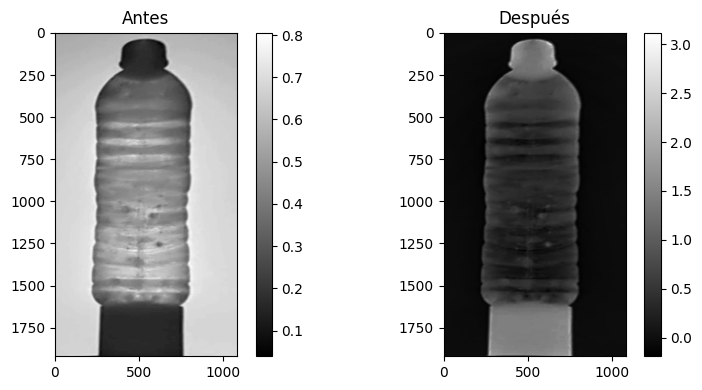

In [20]:
fig2 = plt.figure(figsize=(8,4))

ax1 = fig2.add_subplot(1,2,1)
img1 = ax1.imshow(scan[32], cmap = 'gray')
ax1.set_title('Antes')
# ax1.axis('off')

ax2 = fig2.add_subplot(1,2,2)
img2 = ax2.imshow(scan_clean[32], cmap = 'gray')
ax2.set_title('Después')
# ax2.axis('off')

fig2.colorbar(img1, ax = ax1)
fig2.colorbar(img2, ax = ax2)
fig2.tight_layout()
plt.show()

<h2>2. Obtención de los sinogramas</h2>

In [21]:
# scan_clean.shape = (992, 1920, 1080)

n_images = len(scan_clean)
total_rotations = 8 # El conteo de las rotaciones fue realizado durante la grabación del video
frames_per_rotation = int(n_images/total_rotations) # Resultado aproximado

print(f'Se tienen {n_images} imágenes de la botella en {total_rotations} vueltas contadas. Por lo tanto, en una vuelta hay {frames_per_rotation} imágenes.')

angle_per_image = 360/frames_per_rotation
print(f'\nPor cada imagen el objeto rota {np.round(angle_per_image,2)}°.')

theta = np.arange(0,360,angle_per_image)

Se tienen 992 imágenes de la botella en 8 vueltas contadas. Por lo tanto, en una vuelta hay 124 imágenes.

Por cada imagen el objeto rota 2.9°.


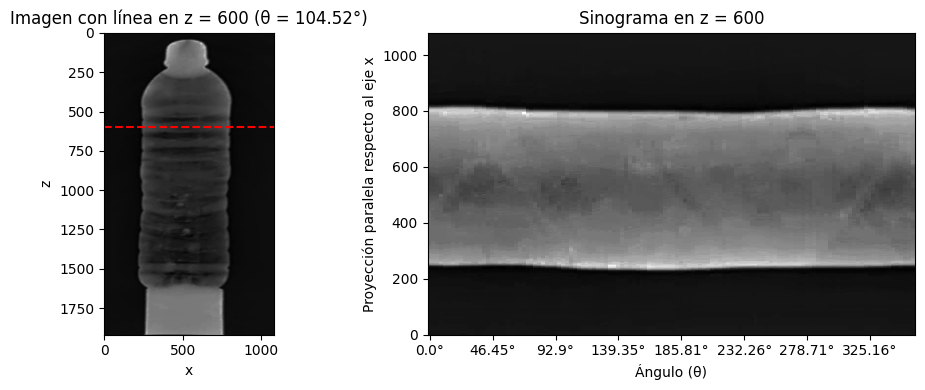

In [22]:
sinograms = np.zeros((frame_height, frame_width, frames_per_rotation)) # (1920, 1080, 124)

# Se tendrán 1920 sinogramas, donde cada uno contará con 124 proyecciones

for j in range(frame_height):
    for k in range(frames_per_rotation):
        k_frame = scan_clean[k]
        projection = k_frame[j,:] # Obtengo la proyección de una línea de la imagen y ángulo dados
        sinograms[j,:,k] = projection 
        
        # Cada proyección para los ángulos establecidos se usan para formar el sinograma para una línea dada de la imagen
        # Utilizando los sinogramas, se generarán tomogramas que representan la sección transversal del objeto respecto de cada una de las líneas
        # Finalmente, a través de la agrupación de los tomogramas obtenidos se realizará la representación 3D de la botella

frame_ex1 = 37
ang_frame_ex1 = (frame_ex1 - 1)*angle_per_image # La primera imagen es de ángulo 0°, por eso se le resta el 1
        
fig3 = plt.figure(figsize=(10,4))

ax1 = fig3.add_subplot(1,2,1)
ax1.imshow(scan_clean[frame_ex1], cmap = 'gray')
ax1.set_title(f'Imagen con línea en z = 600 (θ = {round(ang_frame_ex1,2)}°)')
ax1.axhline(y = 600, color = 'red', linestyle='--')
ax1.set_xlabel('x')
ax1.set_ylabel('z')

ax2 = fig3.add_subplot(1,2,2)
ax2.pcolor(theta, range(len(sinograms[600 - 1])), sinograms[600 - 1], cmap = 'gray') # sinograms[600 - 1] corresponde a la línea z = 600
# ax2.axvline(x = theta[frame_ex1 - 1], color = 'red', linestyle='--')
ax2.set_title('Sinograma en z = 600')
ax2.set_xlabel('Ángulo (θ)')
ax2.set_ylabel('Proyección paralela respecto al eje x')
theta_for_ex = np.arange(0,360,angle_per_image*16)
ax2.set_xticks(ticks = theta_for_ex, labels = [str(round(val,2))+"°" for val in theta_for_ex])

fig3.tight_layout()
plt.show()

# https://github.com/Navid360/CT-Scan-with-visible-light/blob/main/A1_ConstructSinogram.m
# https://www.instructables.com/Desktop-CT-and-3D-Scanner-With-Arduino/
# https://www.youtube.com/watch?v=zSJMhFrXt4A
# https://www.youtube.com/watch?v=dCDwg6ikhAM
# https://dspace.unila.edu.br/bitstream/handle/123456789/5622/TCC%20FINALIZADO%20UNILA%20Cristhian%20Vega%20Mernes.pdf?sequence=1&isAllowed=y
# https://www.youtube.com/watch?v=gaiCtdo6CLE

<h2>3. Obtención de las tomografías a través de la retroproyección filtrada</h2>

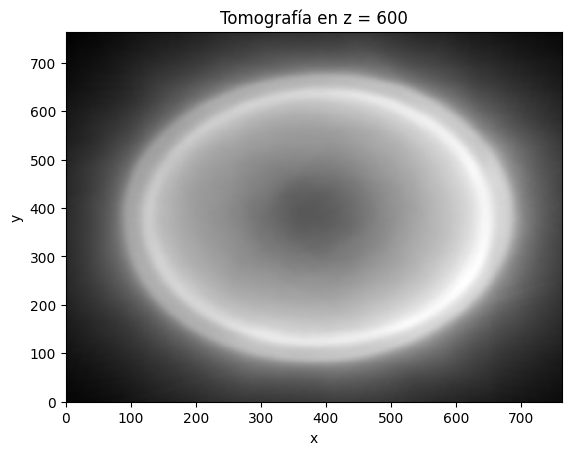

In [24]:
# Primero, se comenzará trabajando con un solo corte transversal y luego se extenderá al resto:

sinogram_z_600 = sinograms[600 - 1] # Se extrae el sinograma en z = 600

# Se reconstruye la tomografía en z = 600 aplicando solamente backprojection:
tomography_xy_z600 = iradon(sinogram_z_600, theta=theta, filter_name=None, circle = False) 

plt.pcolor(tomography_xy_z600, cmap = 'gray')
plt.title('Tomografía en z = 600')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.iradon

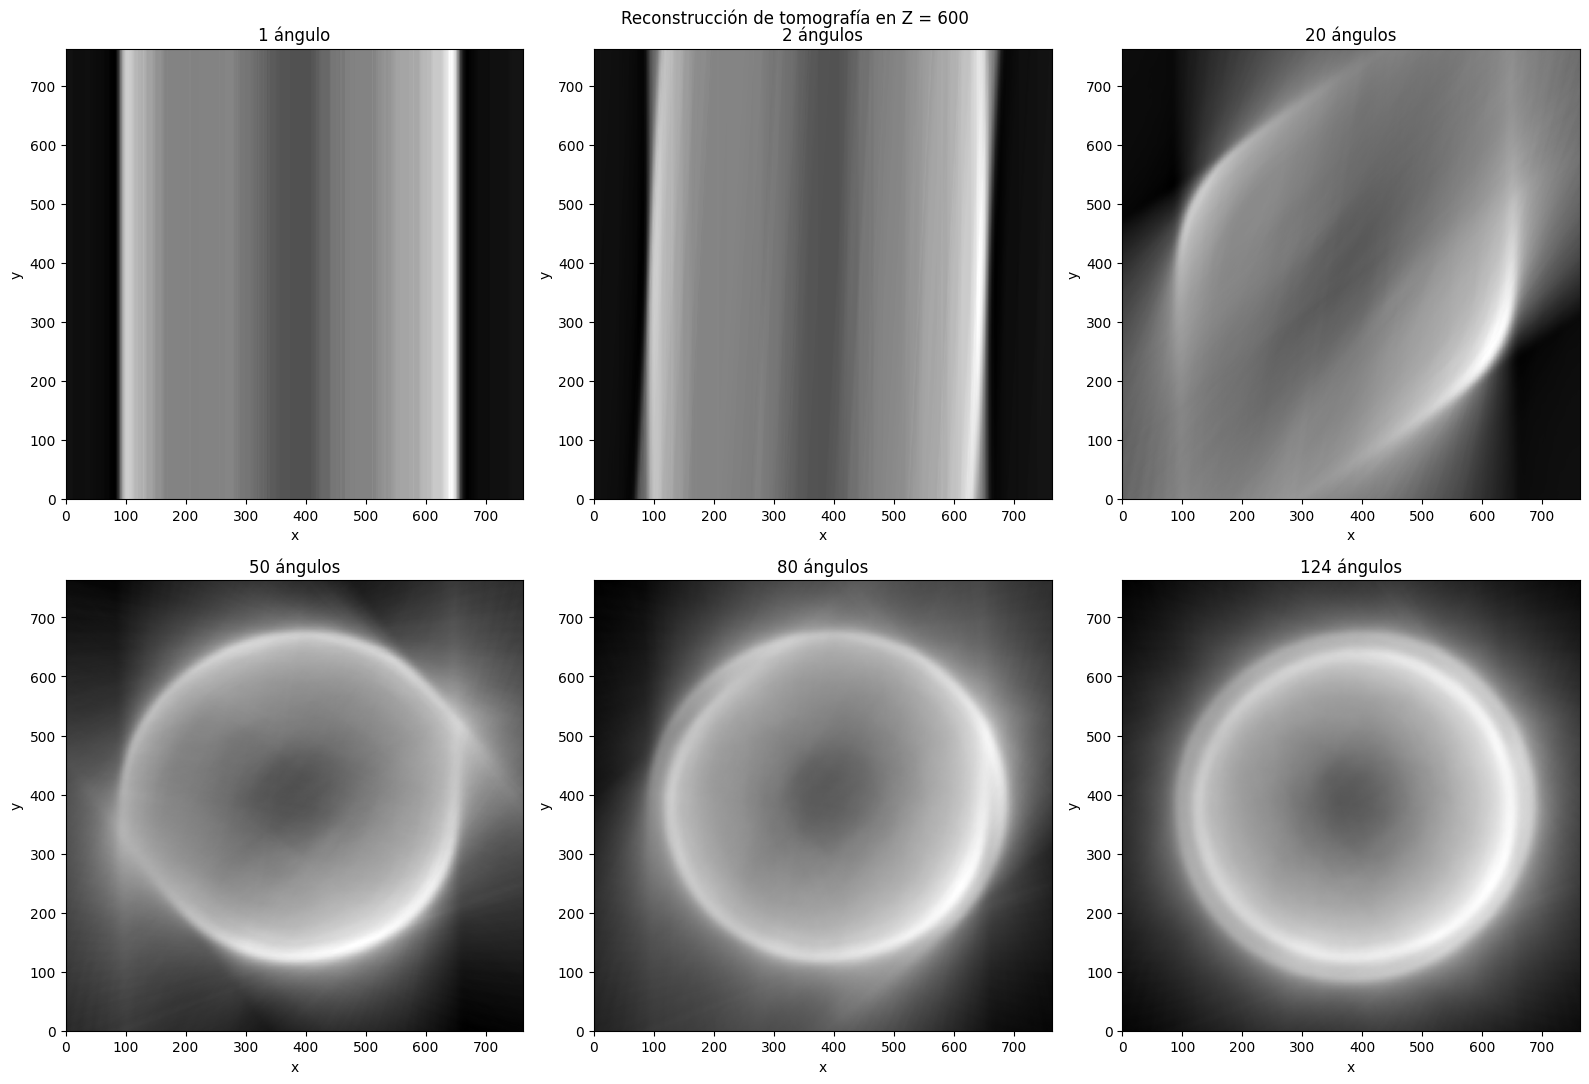

In [11]:
tomography_xy_z600_1 = iradon(sinogram_z_600[:,:1], theta=theta[:1], filter_name=None, circle = False) 
tomography_xy_z600_2 = iradon(sinogram_z_600[:,:2], theta=theta[:2], filter_name=None, circle = False) 
tomography_xy_z600_20 = iradon(sinogram_z_600[:,:20], theta=theta[:20], filter_name=None, circle = False) 
tomography_xy_z600_100 = iradon(sinogram_z_600[:,:50], theta=theta[:50], filter_name=None, circle = False) 
tomography_xy_z600_400 = iradon(sinogram_z_600[:,:80], theta=theta[:80], filter_name=None, circle = False) 
tomography_xy_z600_1920 = iradon(sinogram_z_600, theta=theta, filter_name=None, circle = False) 

fig13 = plt.figure(figsize=(16,16))

fig13.suptitle('Reconstrucción de tomografía en Z = 600')

ax1 = fig13.add_subplot(3,3,1)
ax1.pcolor(tomography_xy_z600_1, cmap = 'gray')
ax1.set_title('1 ángulo')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig13.add_subplot(3,3,2)
ax2.pcolor(tomography_xy_z600_2, cmap = 'gray')
ax2.set_title('2 ángulos')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig13.add_subplot(3,3,3)
ax3.pcolor(tomography_xy_z600_20, cmap = 'gray')
ax3.set_title('20 ángulos')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

ax4 = fig13.add_subplot(3,3,4)
ax4.pcolor(tomography_xy_z600_100, cmap = 'gray')
ax4.set_title('50 ángulos')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

ax5 = fig13.add_subplot(3,3,5)
ax5.pcolor(tomography_xy_z600_400, cmap = 'gray')
ax5.set_title('80 ángulos')
ax5.set_xlabel('x')
ax5.set_ylabel('y')

ax6 = fig13.add_subplot(3,3,6)
ax6.pcolor(tomography_xy_z600_1920, cmap = 'gray')
ax6.set_title('124 ángulos')
ax6.set_xlabel('x')
ax6.set_ylabel('y')

fig13.tight_layout()
plt.show()

<p style="text-align: justify;">Como se puede observar, al aplicar el método de backprojection mediante la Transformada Inversa de Radon al sinograma obtenido en z = 600, se obtiene la imagen de tomografía transversal con respecto a dicho eje. No obstante, es crucial destacar que la imagen resultante presenta cierto grado de borrosidad debido al método utilizado.<br>Con el objetivo de mejorar la calidad de la reconstrucción, se hace necesario aplicar un filtro pasaaltos a la tomografía. Las áreas borrosas en la imagen corresponden a bajas frecuencias (cambios de intensidad suaves por píxel), mientras que las regiones que representan los bordes del objeto corresponden a altas frecuencias (cambios de intensidad abruptos por píxel), las cuales deben ser amplificadas. Este proceso de filtrado se aplicará a cada una de las proyecciones de los sinogramas correspondientes.</p>

<p style="text-align: justify;">Para diseñar el filtro rampa, se utilizará su respuesta al impulso, para a partir de ella obtener la respuesta en frecuencia del filtro que será la utilizada para filtrar las tomografías a través de una multiplicación con las mismas, evitando tener que realizar una convolución en el dominio del tiempo. </p>

<p style="text-align: justify;">Entonces, la respuesta al impulso del filtro rampa con un periodo de muestreo igual a 1 es: </p>

\begin{equation}
h(n) = 
\begin{cases}
    0.25 & \text{if } n = 0 \\
    0 & \text{if } \textit{n es par} \\
    -\frac{1}{n^2 \cdot \pi^2} & \text{if } \textit{n es impar} \\
\end{cases}
\end{equation}








In [26]:
# https://github.com/scikit-image/scikit-image/blob/v0.21.0/skimage/transform/radon_transform.py#L176-L304

# A continuación se arma una función que contendrá todos los filtros a usar:

def filtros(size, filter_name):
    
    # Se arma la respuesta al impulso del filtro rampa:
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int), np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2
    
    # Se aplica la transformada de Fourier sobre la respuesta al impulso del filtro para obtener la respuesta en frecuencia del mismo:
    fourier_filter = 2 * np.real(np.fft.fft(f)) # Se lo multiplica por dos para escalar su máximo valor a 1
    
    k = np.arange(1, size + 1, 1, dtype=int)
    k_corte = int(size/2)
    
    if filter_name == "ramp":
        pass
    
    elif filter_name == "ramp_hamming":
        # fourier_filter *= np.fft.fftshift(np.hamming(size))
        # f = np.real(np.fft.ifft(fourier_filter))
        
        # Respuesta en frecuencia del filtro Hamming:
        hamming = 0.5 + 0.5*np.cos(np.pi*k/k_corte)
        
        # Se realiza la multiplicación en el dominio de la frecuencia entre el filtro rampa (pasaaltos) y el filtro hamming (pasabajos):
        fourier_filter *= hamming
        
        f = np.real(np.fft.fft(fourier_filter))
        
    elif filter_name == "butterworth":
            
        # Función transferencia del filtro butterworth:
        b, a = signal.butter(1, 0.4, 'highpass')
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
        
        # Respuesta en frecuencia del filtro butterworth:
        w, fourier_filter = signal.freqz(b, a, whole = True, worN = size)
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html
        
        # Respuesta al impulso del filtro butterworth:
        f = np.real(np.fft.ifft(fourier_filter))

    elif filter_name is None:
        fourier_filter[:] = 1

    return [f,fourier_filter[:, np.newaxis]]

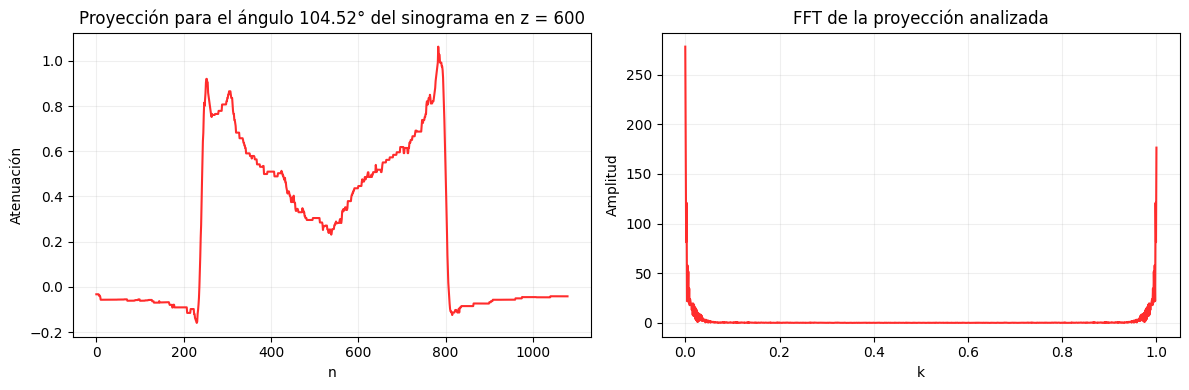

In [27]:
# Primero se comenzará trabajando solamente con una proyección para observar los resultados:

proj_1 = sinogram_z_600[:,frame_ex1-1] # El ángulo seleccionado correspondería al frame N° 37

img_shape = sinogram_z_600.shape[0] # sinogram_z_600.shape = (1080, 124)

output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

# Se calcula la respuesta en frecuencia de la proyección:
fft_proj_1 = np.fft.fft(proj_1)

N = len(proj_1)
k = np.arange(N)
k_norm = k/(np.max(k))

fig5 = plt.figure(figsize=(12,4))

ax1 = fig5.add_subplot(1,2,1)
ax1.plot(proj_1, c='#ff2c2c') # frame_ex1-1: Frame correspondiente al ángulo 244,53°
ax1.set_title(f'Proyección para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
ax1.set_ylabel('Atenuación')
ax1.set_xlabel('n')
ax1.grid(alpha = 0.2)

ax2 = fig5.add_subplot(1,2,2)
ax2.plot(k_norm, abs(fft_proj_1), c='#ff2c2c')
ax2.set_ylabel('Amplitud')
ax2.set_xlabel('k')
ax2.set_title('FFT de la proyección analizada')
# ax2.set_xlim(0,0.2)
ax2.grid(alpha = 0.2)

fig5.tight_layout()
plt.show()

In [28]:
# Uso la función creada anteriormente para probar el filtro rampa:
ramp_filter, ramp_filter_fft = filtros(img_shape,'ramp')

# Multiplico en el espectro de frecuencias el filtro rampa y la proyección analizada (sería una convolución en el dominio del tiempo):
sinogram_ramp_filtered_z_600_fft = np.fft.fft(sinogram_z_600, axis=0) * ramp_filter_fft

# Mediante la Transformada Inversa de Fourier, obtengo la proyección filtrada (sacándoles también el relleno agregado):
sinogram_ramp_filtered_z_600 = np.real(np.fft.ifft(sinogram_ramp_filtered_z_600_fft, axis=0)) # radon_filtered.shape = (1080, 124)

# Aplico la Transformada Inversa de Radon para obtener la tomografía en z = 600:
tomography_xy_z600_ramp_filtered = iradon(sinogram_ramp_filtered_z_600, theta=theta, filter_name=None, circle = False)

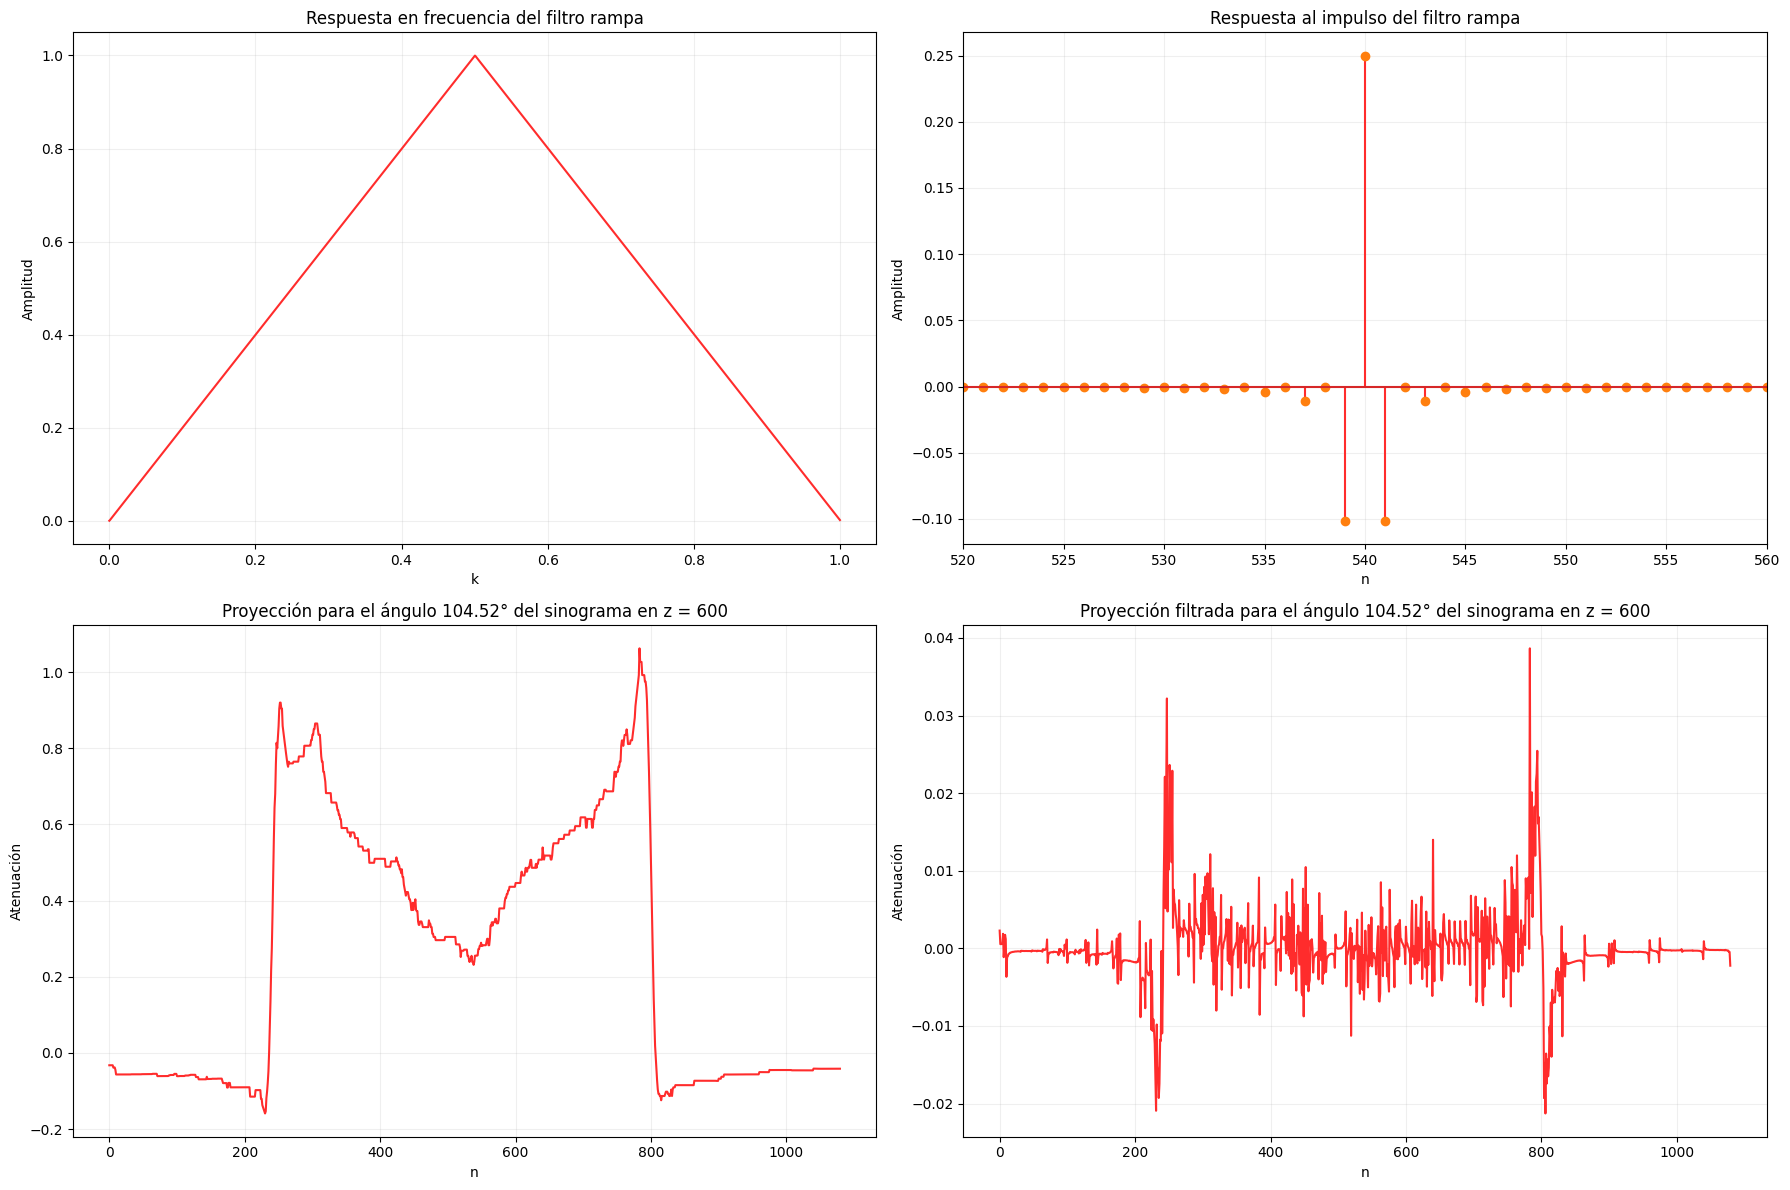

In [29]:
fig6 = plt.figure(figsize=(18,12))

ax1 = fig6.add_subplot(2,2,1)
ax1.plot(k_norm,ramp_filter_fft, c='#ff2c2c')
ax1.set_title('Respuesta en frecuencia del filtro rampa')
ax1.set_xlabel('k')
ax1.set_ylabel('Amplitud')
ax1.grid(alpha = 0.2)

ax2 = fig6.add_subplot(2,2,2)
ax2.stem(np.fft.fftshift(ramp_filter), linefmt='#ff2c2c', markerfmt='C1o')
ax2.set_ylabel('Amplitud')
ax2.set_xlabel('n')
ax2.set_title('Respuesta al impulso del filtro rampa')
ax2.set_xlim(520,560)
ax2.grid(alpha = 0.2)

ax3 = fig6.add_subplot(2,2,3)
ax3.plot(proj_1, c='#ff2c2c') # frame_ex1-1: Frame correspondiente al ángulo 244,53°
ax3.set_title(f'Proyección para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
ax3.set_ylabel('Atenuación')
ax3.set_xlabel('n')
ax3.grid(alpha = 0.2)

ax4 = fig6.add_subplot(2,2,4)
ax4.plot(sinogram_ramp_filtered_z_600[:,frame_ex1-1], c='#ff2c2c')
ax4.set_ylabel('Atenuación')
ax4.set_xlabel('n')
ax4.set_title(f'Proyección filtrada para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
# ax4.set_xlim(0,10)
ax4.grid(alpha = 0.2)

fig6.tight_layout()
plt.show()

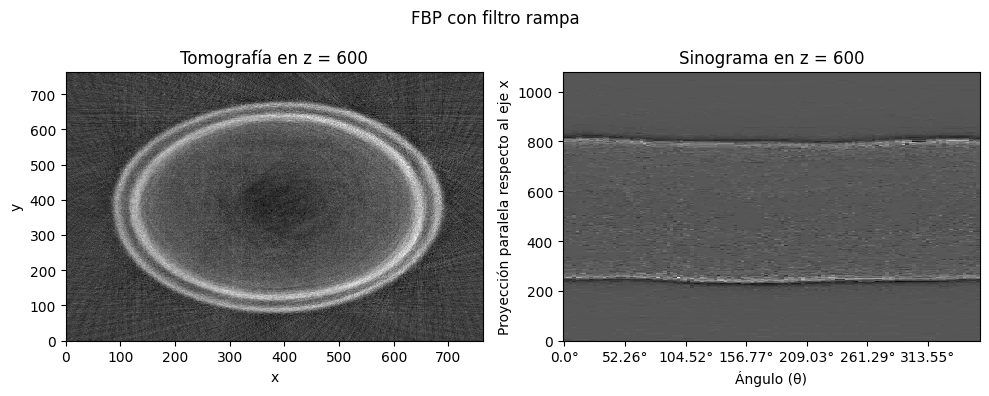

In [30]:
fig7 = plt.figure(figsize=(10,4))

fig7.suptitle('FBP con filtro rampa')

ax1 = fig7.add_subplot(1,2,1)
ax1.pcolor(tomography_xy_z600_ramp_filtered, cmap = 'gray')
ax1.set_title('Tomografía en z = 600')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig7.add_subplot(1,2,2)
ax2.pcolor(theta, range(len(sinogram_ramp_filtered_z_600)), sinogram_ramp_filtered_z_600, cmap = 'gray')
ax2.set_title('Sinograma en z = 600')
ax2.set_xlabel('Ángulo (θ)')
ax2.set_ylabel('Proyección paralela respecto al eje x')
theta_for_ex = np.arange(0,360,angle_per_image*18)
ax2.set_xticks(ticks = theta_for_ex, labels = [str(round(val,2))+"°" for val in theta_for_ex])

fig7.tight_layout()
plt.show()

In [31]:
# Uso la función creada anteriormente para probar el filtro ramp-hamming:
ramp_hamming_filter, ramp_hamming_filter_fft = filtros(img_shape,'ramp_hamming')

# Multiplico en el espectro de frecuencias el filtro rampa y la proyección analizada (sería una convolución en el dominio del tiempo):
sinogram_ramp_hamming_filtered_z_600_fft = np.fft.fft(sinogram_z_600, axis=0) * ramp_hamming_filter_fft

# Mediante la Transformada Inversa de Fourier, obtengo la proyección filtrada (sacándoles también el relleno agregado):
sinogram_ramp_hamming_filtered_z_600 = np.real(np.fft.ifft(sinogram_ramp_hamming_filtered_z_600_fft, axis=0)) # radon_filtered.shape = (1080, 124)

# Aplico la Transformada Inversa de Radon para obtener la tomografía en z = 600:
tomography_xy_z600_ramp_hamming_filtered = iradon(sinogram_ramp_hamming_filtered_z_600, theta=theta, filter_name=None, circle = False)

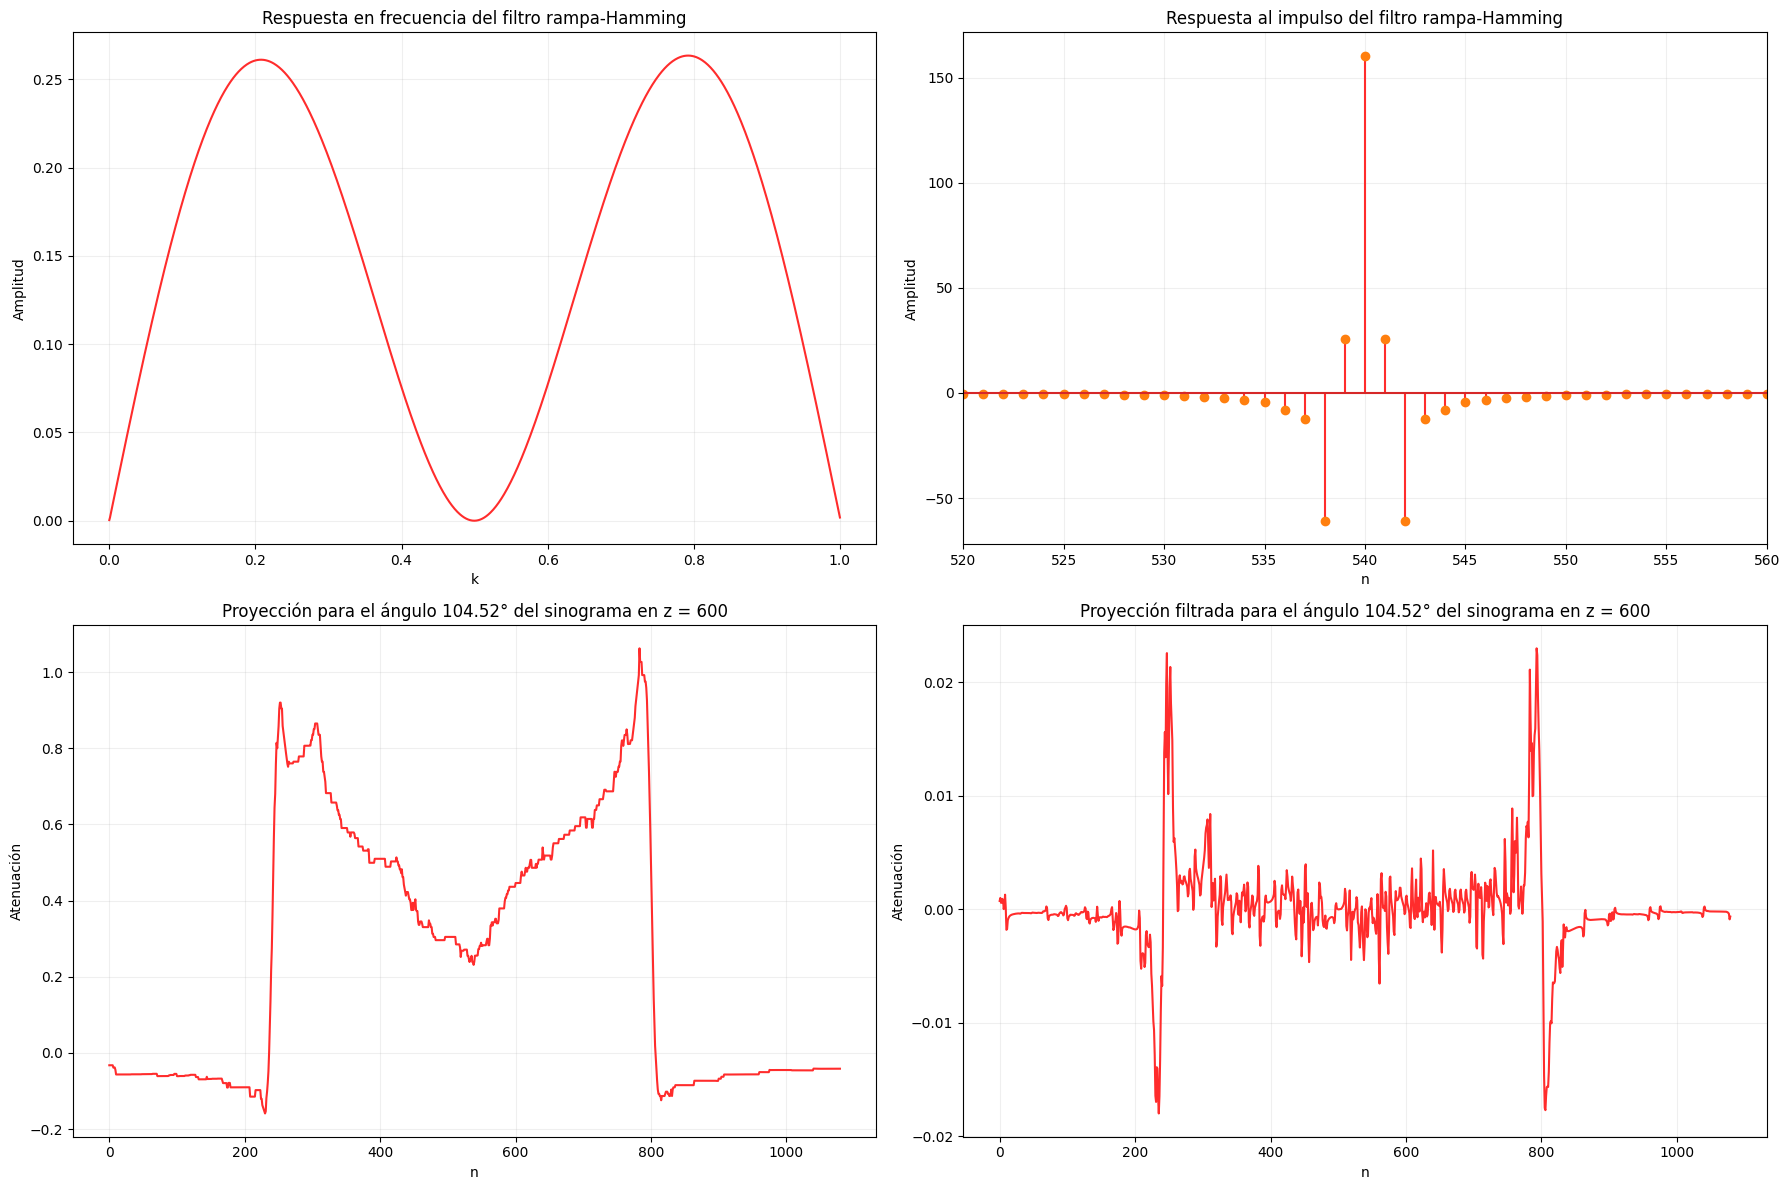

In [32]:
fig10 = plt.figure(figsize=(18,12))

ax1 = fig10.add_subplot(2,2,1)
ax1.plot(k_norm,ramp_hamming_filter_fft, c='#ff2c2c')
ax1.set_title('Respuesta en frecuencia del filtro rampa-Hamming')
ax1.set_xlabel('k')
ax1.set_ylabel('Amplitud')
ax1.grid(alpha = 0.2)

ax2 = fig10.add_subplot(2,2,2)
ax2.stem(np.fft.fftshift(ramp_hamming_filter), linefmt='#ff2c2c', markerfmt='C1o')
ax2.set_ylabel('Amplitud')
ax2.set_xlabel('n')
ax2.set_title('Respuesta al impulso del filtro rampa-Hamming')
ax2.set_xlim(520,560)
ax2.grid(alpha = 0.2)

ax3 = fig10.add_subplot(2,2,3)
ax3.plot(proj_1, c='#ff2c2c') # frame_ex1-1: Frame correspondiente al ángulo 244,53°
ax3.set_title(f'Proyección para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
ax3.set_ylabel('Atenuación')
ax3.set_xlabel('n')
ax3.grid(alpha = 0.2)

ax4 = fig10.add_subplot(2,2,4)
ax4.plot(sinogram_ramp_hamming_filtered_z_600[:,frame_ex1-1], c='#ff2c2c')
ax4.set_ylabel('Atenuación')
ax4.set_xlabel('n')
ax4.set_title(f'Proyección filtrada para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
# ax4.set_xlim(0,10)
ax4.grid(alpha = 0.2)

fig10.tight_layout()
plt.show()

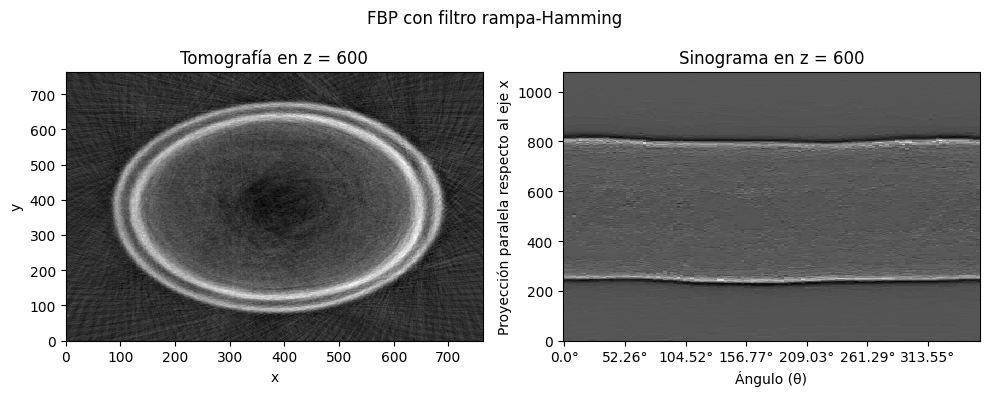

In [33]:
fig11 = plt.figure(figsize=(10,4))

fig11.suptitle('FBP con filtro rampa-Hamming')

ax1 = fig11.add_subplot(1,2,1)
ax1.pcolor(tomography_xy_z600_ramp_hamming_filtered, cmap = 'gray')
ax1.set_title('Tomografía en z = 600')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig11.add_subplot(1,2,2)
ax2.pcolor(theta, range(len(sinogram_ramp_hamming_filtered_z_600)), sinogram_ramp_hamming_filtered_z_600, cmap = 'gray')
ax2.set_title('Sinograma en z = 600')
ax2.set_xlabel('Ángulo (θ)')
ax2.set_ylabel('Proyección paralela respecto al eje x')
theta_for_ex = np.arange(0,360,angle_per_image*18)
ax2.set_xticks(ticks = theta_for_ex, labels = [str(round(val,2))+"°" for val in theta_for_ex])

fig11.tight_layout()
plt.show()

In [34]:
# Uso la función creada anteriormente para probar el filtro butterworth:
butterworth_filter, butterworth_filter_fft = filtros(img_shape,'butterworth')

# Multiplico en el espectro de frecuencias el filtro butterworth y la proyección analizada (sería una convolución en el dominio del tiempo):
sinogram_butterworth_filtered_z_600_fft = np.fft.fft(sinogram_z_600, axis=0) * butterworth_filter_fft

# Mediante la Transformada Inversa de Fourier, obtengo la proyección filtrada (sacándoles también el relleno agregado):
sinogram_butterworth_filtered_z_600 = np.real(np.fft.ifft(sinogram_butterworth_filtered_z_600_fft, axis=0)) # radon_filtered.shape = (1080, 124)

# Aplico la Transformada Inversa de Radon para obtener la tomografía en z = 600:
tomography_xy_z600_butterworth_filtered = iradon(sinogram_butterworth_filtered_z_600, theta=theta, filter_name=None, circle = False)

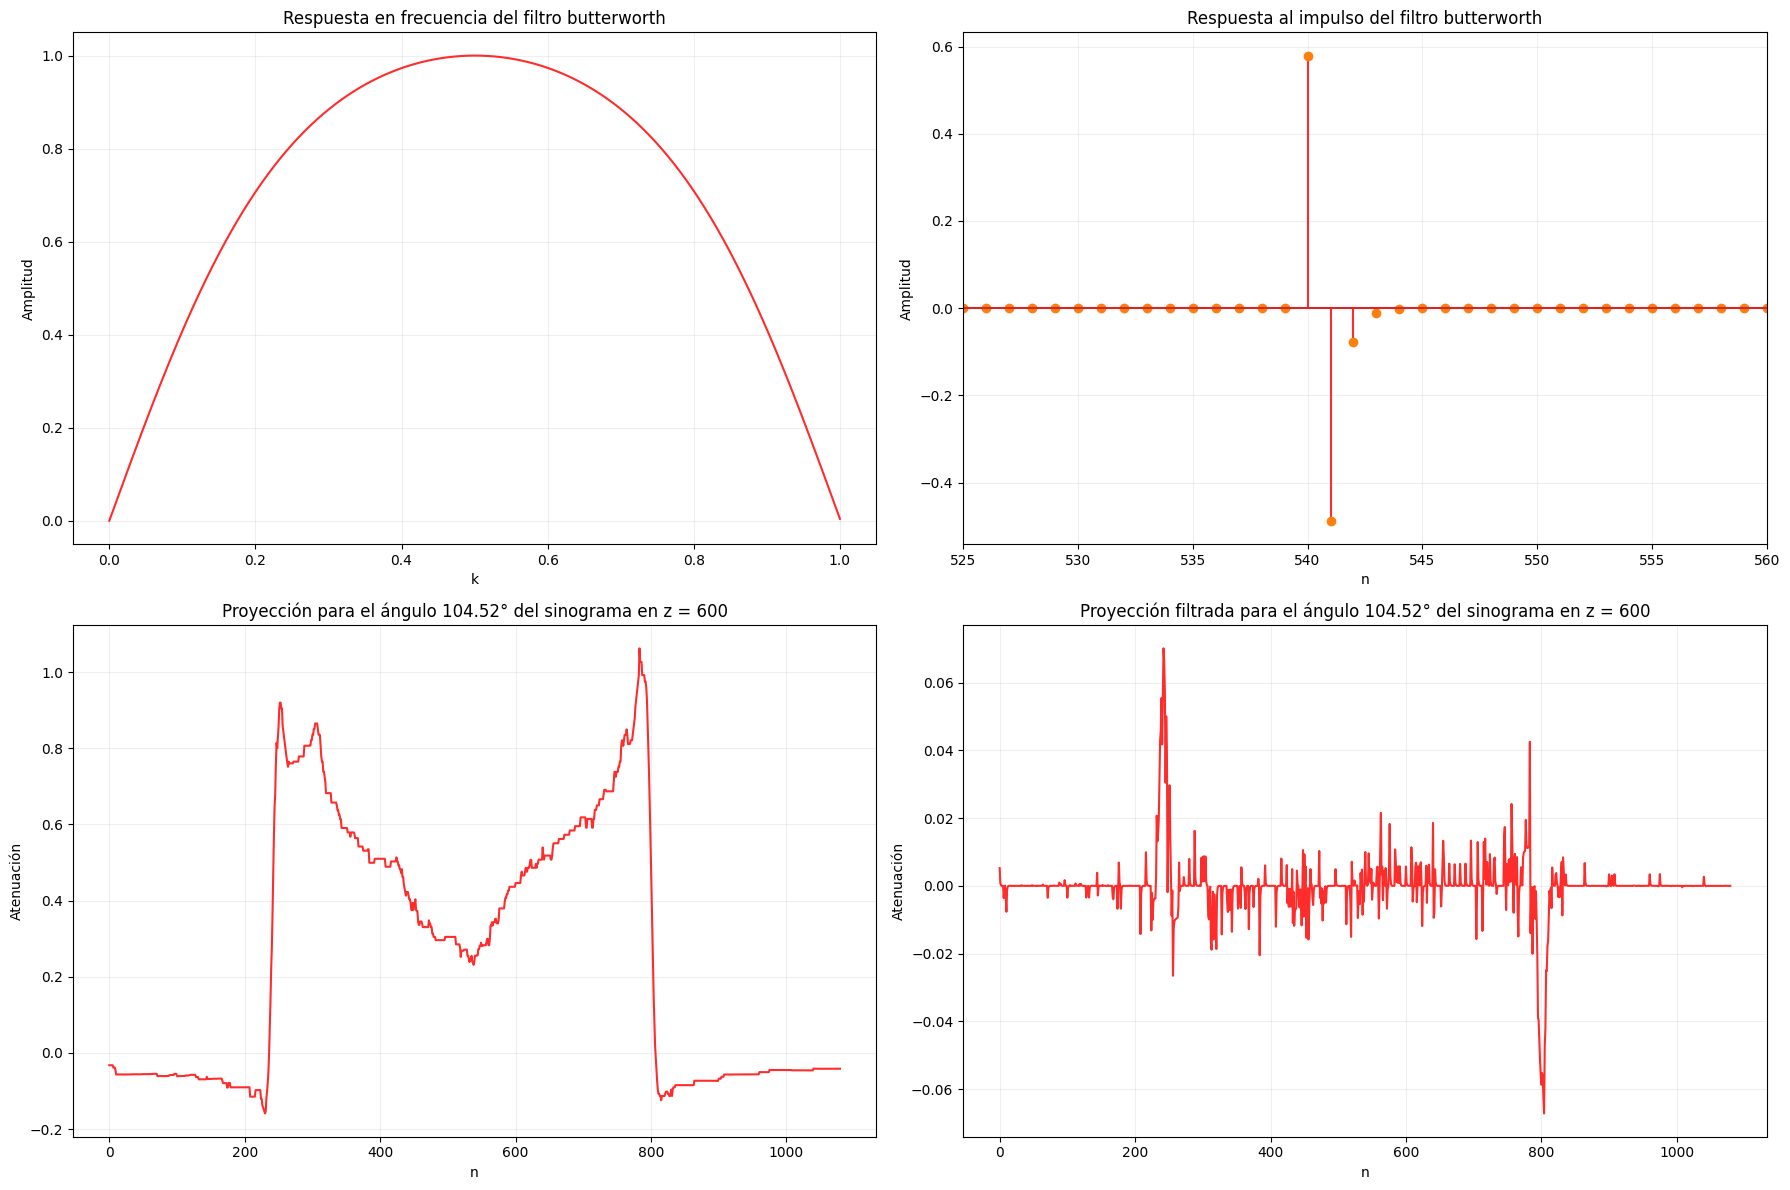

In [35]:
fig12 = plt.figure(figsize=(18,12))

ax1 = fig12.add_subplot(2,2,1)
ax1.plot(k_norm,np.abs(butterworth_filter_fft), c='#ff2c2c')
ax1.set_title('Respuesta en frecuencia del filtro butterworth')
ax1.set_xlabel('k')
ax1.set_ylabel('Amplitud')
ax1.grid(alpha = 0.2)

ax2 = fig12.add_subplot(2,2,2)
ax2.stem(np.fft.fftshift(butterworth_filter), linefmt='#ff2c2c', markerfmt='C1o')
ax2.set_ylabel('Amplitud')
ax2.set_xlabel('n')
ax2.set_title('Respuesta al impulso del filtro butterworth')
ax2.set_xlim(525,560)
ax2.grid(alpha = 0.2)

ax3 = fig12.add_subplot(2,2,3)
ax3.plot(proj_1, c='#ff2c2c') # frame_ex1-1: Frame correspondiente al ángulo 244,53°
ax3.set_title(f'Proyección para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
ax3.set_ylabel('Atenuación')
ax3.set_xlabel('n')
ax3.grid(alpha = 0.2)

ax4 = fig12.add_subplot(2,2,4)
ax4.plot(sinogram_butterworth_filtered_z_600[:,frame_ex1-1], c='#ff2c2c')
ax4.set_ylabel('Atenuación')
ax4.set_xlabel('n')
ax4.set_title(f'Proyección filtrada para el ángulo {round(ang_frame_ex1,2)}° del sinograma en z = 600')
# ax4.set_xlim(0,10)
ax4.grid(alpha = 0.2)

fig12.tight_layout()
plt.show()

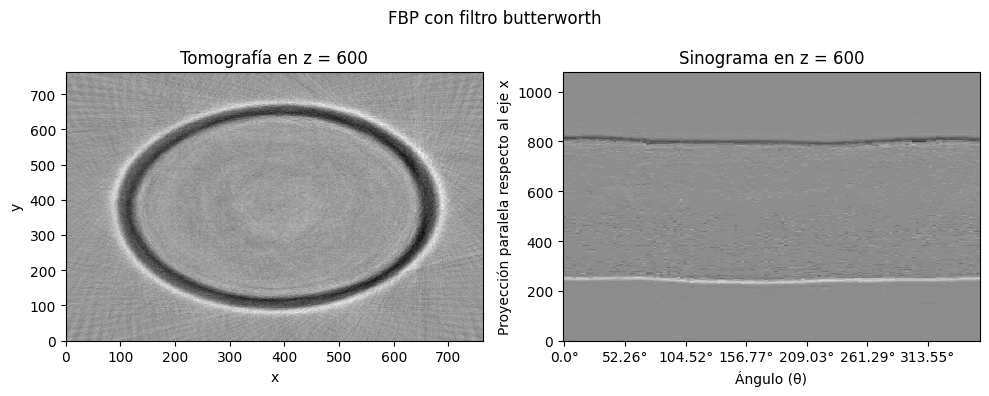

In [36]:
fig11 = plt.figure(figsize=(10,4))

fig11.suptitle('FBP con filtro butterworth')

ax1 = fig11.add_subplot(1,2,1)
ax1.pcolor(tomography_xy_z600_butterworth_filtered, cmap = 'gray')
ax1.set_title('Tomografía en z = 600')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig11.add_subplot(1,2,2)
ax2.pcolor(theta, range(len(sinogram_butterworth_filtered_z_600)), sinogram_butterworth_filtered_z_600, cmap = 'gray')
ax2.set_title('Sinograma en z = 600')
ax2.set_xlabel('Ángulo (θ)')
ax2.set_ylabel('Proyección paralela respecto al eje x')
theta_for_ex = np.arange(0,360,angle_per_image*18)
ax2.set_xticks(ticks = theta_for_ex, labels = [str(round(val,2))+"°" for val in theta_for_ex])

fig11.tight_layout()
plt.show()

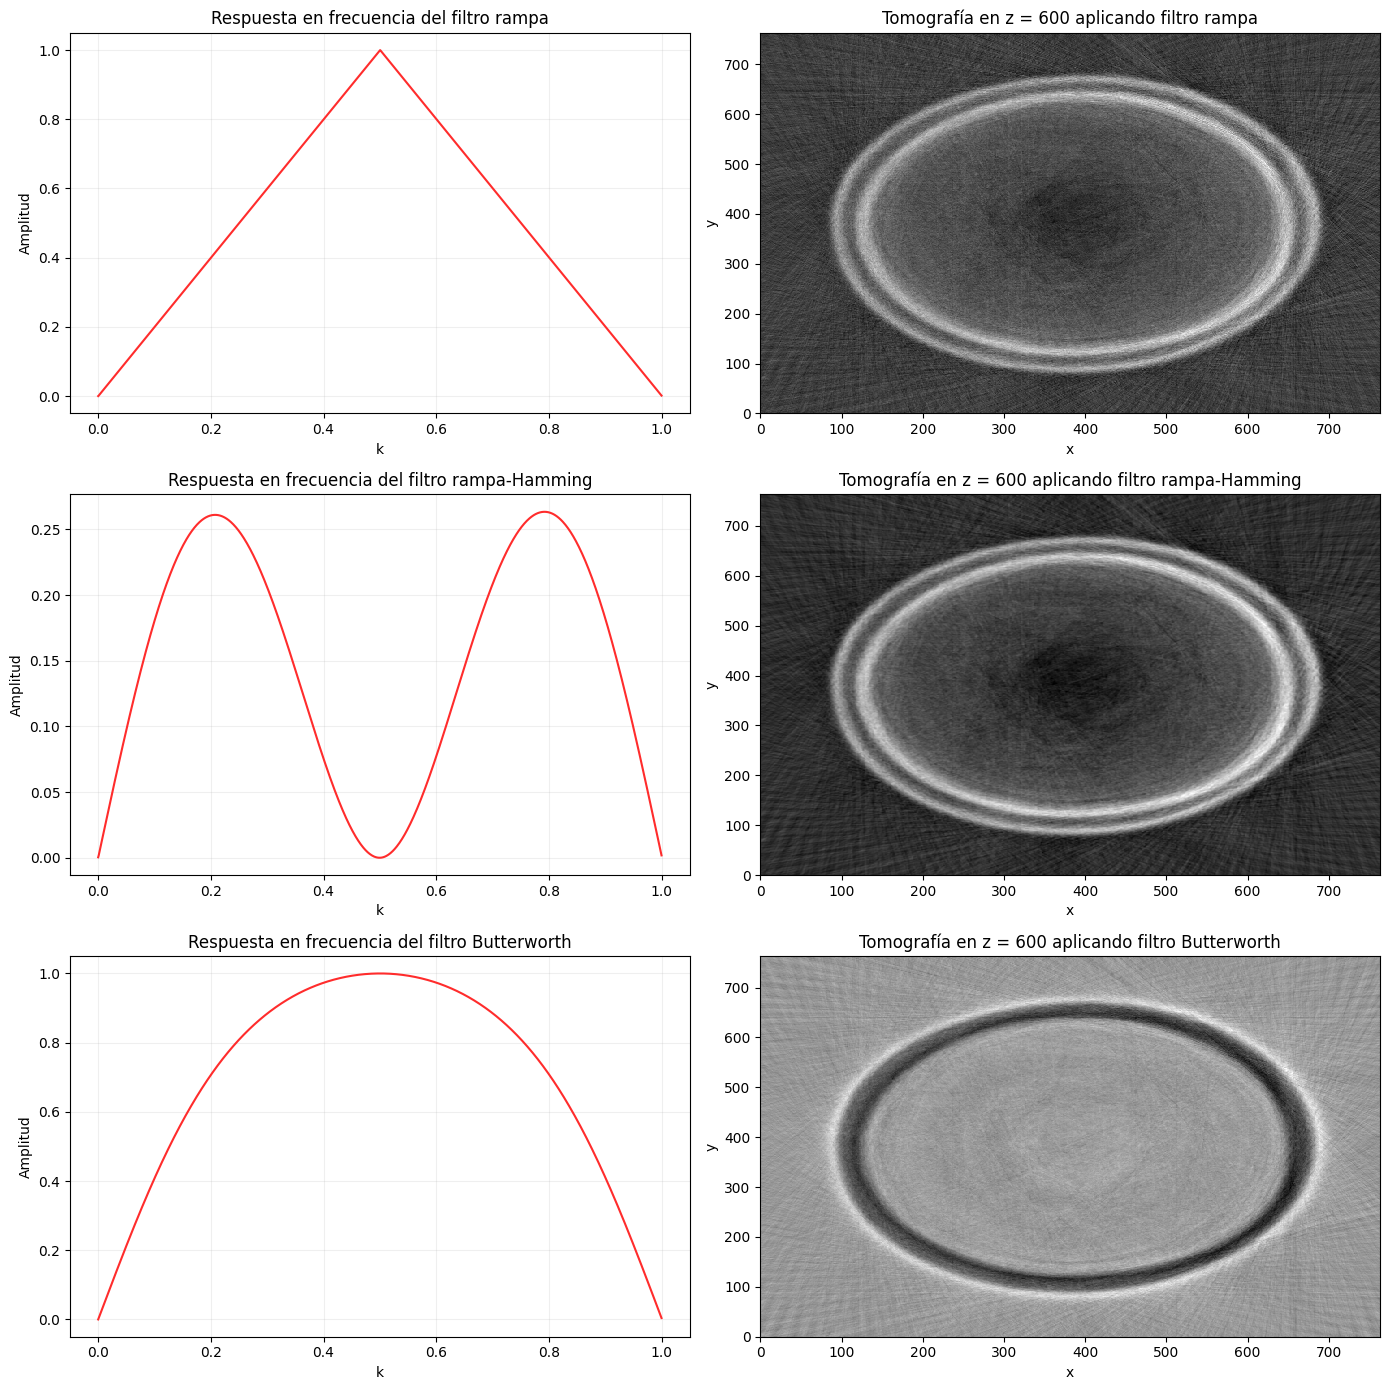

In [41]:
fig14 = plt.figure(figsize=(14,14))

ax1 = fig14.add_subplot(3,2,1)
ax1.plot(k_norm,ramp_filter_fft, c='#ff2c2c')
ax1.set_title('Respuesta en frecuencia del filtro rampa')
ax1.set_xlabel('k')
ax1.set_ylabel('Amplitud')
ax1.grid(alpha = 0.2)

ax2 = fig14.add_subplot(3,2,2)
ax2.pcolor(tomography_xy_z600_ramp_filtered, cmap = 'gray')
ax2.set_title('Tomografía en z = 600 aplicando filtro rampa')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig14.add_subplot(3,2,3)
ax3.plot(k_norm,ramp_hamming_filter_fft, c='#ff2c2c')
ax3.set_title('Respuesta en frecuencia del filtro rampa-Hamming')
ax3.set_xlabel('k')
ax3.set_ylabel('Amplitud')
ax3.grid(alpha = 0.2)

ax4 = fig14.add_subplot(3,2,4)
ax4.pcolor(tomography_xy_z600_ramp_hamming_filtered, cmap = 'gray')
ax4.set_title('Tomografía en z = 600 aplicando filtro rampa-Hamming')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

ax5 = fig14.add_subplot(3,2,5)
ax5.plot(k_norm,np.abs(butterworth_filter_fft), c='#ff2c2c')
ax5.set_title('Respuesta en frecuencia del filtro Butterworth')
ax5.set_xlabel('k')
ax5.set_ylabel('Amplitud')
ax5.grid(alpha = 0.2)

ax6 = fig14.add_subplot(3,2,6)
ax6.pcolor(tomography_xy_z600_butterworth_filtered, cmap = 'gray')
ax6.set_title('Tomografía en z = 600 aplicando filtro Butterworth')
ax6.set_xlabel('x')
ax6.set_ylabel('y')

fig14.tight_layout()
plt.show()

In [30]:
# Ahora, se aplica para cada uno de los sinogramas para reconstruir la botella:

n_tomo = 1920

tomographies_xy = np.zeros((n_tomo, output_size, output_size))

for i in tqdm(range(n_tomo)):
    sinogram_i = sinograms[i]
    sinogram_i_filtered_fft = np.fft.fft(sinogram_i, axis=0) * ramp_hamming_filter_fft
    sinogram_i_filtered = np.real(np.fft.ifft(sinogram_i_filtered_fft, axis=0))
    tomographies_xy[i,:,:] = iradon(sinogram_i_filtered, theta = theta, filter_name = None, circle = None)

100%|██████████████████████████████████████████████████████████████████████████████| 1920/1920 [29:49<00:00,  1.07it/s]


In [ ]:
# Como la operación tarda en realizarse, se guardan las tomografías:
np.save("codeData/tomographies_xy", tomographies_xy)

In [ ]:
# Se leen las tomografías guardados (en caso de ser necesario):
tomographies_xy = np.load("codeData/tomographies_xy.npy")

<p style="text-align: justify;">Para ver la representación 3D del objeto empleando el paquete de procesamiento de imágenes Fiji (Fiji Is Just ImageJ), la matriz tridimensional con cada una de las tomografías tiene que ser uint8 (Unsigned integer - 0 a 255). Por lo tanto, considerando que actualmente es del tipo float64, se empleará openCV para realizar la operación:</p>

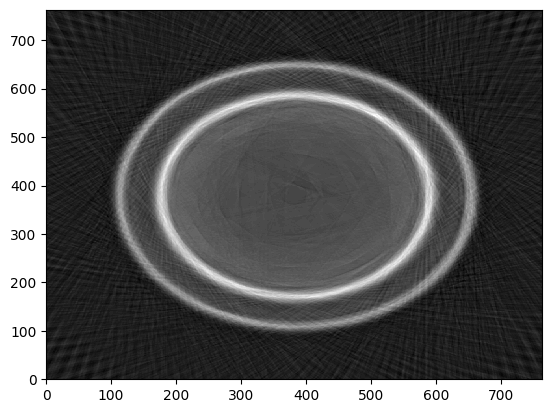

In [33]:
# print(tomographies_xy.dtype)

tomographies_xy_uint8 = cv2.normalize(src=tomographies_xy, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.pcolor(tomographies_xy_uint8[1760], cmap = 'gray')
plt.show()

# Es importante considerar que se perdió cierta información al realizar el cambio del tipo de dato

In [32]:
# https://pypi.org/project/tifffile/#examples

tif.imwrite('CodeData/tomographies_xy.tif', tomographies_xy_uint8, photometric='minisblack')

tif_tomo = tif.TiffFile('CodeData/tomographies_xy.tif')

print(len(tif_tomo.pages))

page = tif_tomo.pages[0]
print(page.shape)

1920
(763, 763)


<h2>4. Reconstrucción tridimensional de la botella</h2>

<p style="text-align: justify;">Utilizando Fiji (Fiji Is Just ImageJ), se ajustó el contraste y el brillo de cada una de las tomografías. Posteriormente, se empleó la función 3D Viewer para crear un volumen que incluyera todas las tomografías que representaban los diversos cortes transversales de la botella, lo que permitió obtener una reconstrucción tridimensional completa de la misma.</p>

<img src='Archivos/Reconstrucción_3D.png' width="600" height="300" style="padding: 20px;">

In [3]:
# # Código auxiliar para reproducir un video:
# bottle_video_transformed = cv2.VideoCapture('codeData/Botella_transformed.mp4')

# bottle_video_transformed.set(cv2.CAP_PROP_POS_FRAMES, 34*fps-1+3)


# while bottle_video_transformed.isOpened():
#     ret4, frame4 = bottle_video_transformed.read()
#     if ret4:
#         cv2.imshow("Video", frame4)
#         if cv2.waitKey(0) == 27: # Esc para salir
#             break
#     else:
#         break
# bottle_video_transformed.release()
# cv2.destroyAllWindows()